In [261]:
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from matplotlib.patches import ArrowStyle
from scipy import stats
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import csv
%matplotlib inline

In [262]:
df = pd.read_csv('./dat', encoding='utf-8', sep=',') # data read
df_proc = df.copy()

In [263]:
df_proc['x0_age'] = df_proc['x0_age'].fillna(df_proc['x0_age'].median())

In [264]:
df_proc['x10'] = df_proc['x10'].fillna(df_proc['x10'].median())

In [265]:
df_hist = df_proc.copy()

In [266]:
df_proc['x58'] = df_proc['x58'].fillna(0)
df_proc['x59'] = df_proc['x59'].fillna(0)
df_proc['x60'] = df_proc['x60'].fillna(0)
df_proc['x61'] = df_proc['x61'].fillna(0)
df_proc['x62'] = df_proc['x62'].fillna(-1)
df_proc['x63'] = df_proc['x63'].fillna(0)
df_proc['x64'] = df_proc['x64'].fillna(99999999)
df_proc['x65'] = df_proc['x65'].fillna(0)
df_proc['x66'] = df_proc['x66'].fillna(0)
df_proc['x67'] = df_proc['x67'].fillna(99)
df_proc['x68'] = df_proc['x68'].fillna(0)
df_proc['x69'] = df_proc['x69'].fillna(0)
df_proc['x70'] = df_proc['x70'].fillna(0)
df_proc['x71'] = df_proc['x71'].fillna(-1)

In [267]:
# one hot encoding
df_proc = pd.get_dummies(df_proc, columns=['x9'])

In [268]:
dfs = df_proc.copy()

In [269]:
drop_col = ['x14','x18','x19','x21','x22','x23','x27','x28','x29','x30','x31','x33','x34','x35','x36','x37','x38','x40','x49','x72']
df_spray = df_proc.drop(drop_col, axis=1)

In [270]:
# 相関があるが、同数の項目値が0⇆99と異なる。「x6」は99→0へ変換する。
df_spray['x6'] = df_spray['x6'].replace(99, 0)

In [271]:
# 相関があるが、同数の項目値が0⇆99と異なる。「x6」は99→0へ変換する。
df_spray['x67'] = df_spray['x67'].replace(99, 0)

In [272]:
# 相関があるが、同数の項目値が0⇆99999999へ変換すると異なる。「x63」は0→99999999へ変換する。
df_spray['x63'] = df_spray['x63'].replace(0, 99999999)

In [273]:
df_del = df_spray.copy()

In [274]:
df_del = df_del.drop(columns='x61')
df_del = df_del.drop(columns='x65')
df_del = df_del.drop(columns='x66')
df_del = df_del.drop(columns='x70')

In [275]:
df_label = df_del.copy()

In [276]:
# ランダム・フォレストによる相互作用評価
X = df_label.drop(columns='y')
y = df_label['y']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=0)

classifier_model = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifier_model.fit(train_X, train_y)

pred_y = classifier_model.predict(test_X)
cm = confusion_matrix(test_y, pred_y)
print(cm)
print(accuracy_score(test_y, pred_y))

[[14929    61]
 [  628   132]]
0.9562539682539682


In [277]:
# Importtance
# 組み込み法（モデルベース特徴量選択：モデルが学習するタイミングで特徴量を評価する）
importance = classifier_model.feature_importances_
importances = pd.DataFrame(importance, index = X.columns, columns=['importance'])
pd.set_option('display.max_rows', 80)
importances.sort_values(by='importance', ascending=False)

,importance
x1_term,0.143358
x10,0.098021
x0_age,0.095925
x5,0.075107
x3,0.058060
x57,0.049504
x6,0.039396
x4,0.038059
x56,0.037499
x2_sex,0.025759


In [278]:
df_zero = df_label.copy()

In [279]:
# 下記も削除対象とする
cols =['x46', 'x48', 'x50', 'x51'] # 'x47'残す
df_zero = df_zero.drop(columns=cols)

In [280]:
# ②他の特徴量と値が完全に一致している変数の片方を削除
train_X_T = train_X.T
duplicated_features = train_X_T[train_X_T.duplicated()].index.values
print(duplicated_features)
# 'x47' 'x48' 'x50' 'x51' ←1つ残す、ただし全て相互作用評価結果(Importance=0)

['x47' 'x48' 'x50' 'x51']


In [281]:
df_add = df_zero.copy()
df_add['x73'] = (df_add['x0_age'] + df_add['x10'])/2
df_add['x74'] = (df_add['x5'] + df_add['x6'])/2
df_add['x75'] = (df_add['x59'] + df_add['x67'])/2
df_add['x76'] = (df_add['x59'] + df_add['x68'])/2
df_add['x77'] = (df_add['x62'] + df_add['x71'])/2
df_add['x78'] = (df_add['x63'] + df_add['x64'])/2

In [282]:
# ランダム・フォレストによる相互作用評価
X_re = df_add.drop(columns='y')
y_re = df_add['y']

train_X_re, test_X_re, train_y_re, test_y_re = train_test_split(X_re, y_re, test_size=0.3, random_state=0)

classifier_model_re = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifier_model_re.fit(train_X_re, train_y_re)

pred_y_re = classifier_model_re.predict(test_X_re)
cm_re = confusion_matrix(test_y_re, pred_y_re)
print(cm_re)
print(accuracy_score(test_y, pred_y))

[[14921    69]
 [  631   129]]
0.9562539682539682


In [283]:
# Importtance
importance_re = classifier_model_re.feature_importances_
importances_re = pd.DataFrame(importance_re, index = X_re.columns, columns=['importance'])
pd.set_option('display.max_rows', 50)
importances_re.sort_values(by='importance', ascending=False)

,importance
x1_term,0.118974
x73,0.080239
x10,0.077516
x0_age,0.073920
x5,0.059724
...,...
x62,0.000701
x71,0.000691
x67,0.000586
x68,0.000526


In [284]:
# Importanceからも削除
print(type(importances_re))
print(importances_re.shape)
importances_re = importances_re.drop('x75', axis=0)
importances_re = importances_re.drop('x76', axis=0)
importances_re = importances_re.drop('x77', axis=0)
importances_re = importances_re.drop('x78', axis=0)

<class 'pandas.core.frame.DataFrame'>
(59, 1)


In [285]:
df_select_del = df_add.copy()
del_col = ['x7', 'x8', 'x11', 'x15', 'x16', 'x24', 'x25', 'x26', 'x32', 'x39','x41', 'x44', 'x47', 'x54', 'x58', 'x59', 'x60', 'x62', 'x63', 'x64','x67', 'x68', 'x69', 'x71']
df_select_del = df_select_del.drop(columns=del_col)

In [286]:
df_light = df_select_del.copy()
df_light.shape

(52500, 36)

In [287]:
# デフォルト値
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'num_leaves': 31,
#     'num_iterations': 100,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'max_depth': ,
#     'min_data_in_leaf': 20,
# }

In [288]:
# # 自動チューニング
# import optuna.integration.lightgbm as lgb_tune

# df_train, df_val =train_test_split(df_light, test_size=0.2)
 
# col = "y"
# train_y = df_train[col]
# train_x = df_train.drop(col, axis=1)
 
# val_y = df_val[col]
# val_x = df_val.drop(col, axis=1)
 
# trains = lgb.Dataset(train_x, train_y)
# valids = lgb.Dataset(val_x, val_y)
 
# model_tune = lgb_tune.train(
#     params, trains, valid_sets=valids, 
#     verbose_eval=100, 
#     early_stopping_rounds=100,
# )
# print(model_tune.params)

# # 予測
# preds = model_tune.predict(train_x)
# # AUC
# fpr, tpr, thresholds = metrics.roc_curve(train_y, preds)
# auc = metrics.auc(fpr, tpr)
# auc

In [289]:
# # ホールドアウト法→交差検証 (クロスバリデーション)に切り替える
# kf = KFold(n_splits=5, shuffle=True, random_state=0)
# predicted_df = pd.DataFrame({'index':0, 'pred':0}, index=[1])

# val_indexs=[]
# i=0
# for train_index, val_index in kf.split(df_light.index):
#     X_train = df_light.drop('y', axis=1).iloc[train_index]
#     y_train = df_light['y'].iloc[train_index]
#     X_test = df_light.drop('y', axis=1).iloc[val_index]
#     y_test = df_light['y'].iloc[val_index]
    
# # XGBoost Modeling
#     clf = XGBClassifier(
#             objective='binary:logistic',
#             num_leaves=31,
#             num_iterations=100,
#             learning_rate=0.1,
#             feature_fraction=1,
#             subsample=1,
#             max_depth=1,
#             min_data_in_leaf=5
#     )
#     metLearn=CalibratedClassifierCV(clf)
#     clf.fit(X_train, y_train)

In [397]:
# ホールドアウト法→交差検証 (クロスバリデーション)に切り替える
kf = KFold(n_splits=5, shuffle=True, random_state=0)
predicted_df = pd.DataFrame({'index':0, 'pred':0}, index=[1])

In [441]:
for train_index, val_index in kf.split(df_light.index):
    X_train = df_light.drop('y', axis=1).iloc[train_index]
    y_train = df_light['y'].iloc[train_index]
    X_test = df_light.drop('y', axis=1).iloc[val_index]
    y_test = df_light['y'].iloc[val_index]
    
# LightGMB Modeling
    gbm = lgb.LGBMClassifier(
            objective='binary',
            num_leaves=30,
            num_iterations=110,
            learning_rate=0.075,
            feature_fraction=0.9,
            bagging_fraction=0.9,
            bagging_freq=1,
            max_depth=9,
            min_data_in_leaf=13,
    )
    metLearn=CalibratedClassifierCV(gbm)
    gbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [442]:
# 予測
Predictions = gbm.predict_proba(X_test)

# AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, Predictions[:,1])
auc = metrics.auc(fpr, tpr)
print('auc: {:.3f}'.format(auc))
# auc: 0.892 最高値

auc: 0.892


In [437]:
# parameter_list = [i for i in range(10,150,10)] # num_leaves
# parameter_list = [i for i in range(10,150,10)] # num_iterations
# parameter_list = [i/1000 for i in range(10,100,5)] # learning_rate
# parameter_list = [i/10 for i in range(1,10,1)] # feature_fraction
# parameter_list = [i/10 for i in range(1,10,1)] # bagging_fraction
# parameter_list = [i for i in range(1,15,1)] # bagging_freq
# parameter_list = [i for i in range(1,15,1)] # max_depth
parameter_list = [i for i in range(1,15,1)] # min_data_in_leaf

aucs = []
for param in parameter_list:
    for train_index, val_index in kf.split(df_light.index):
        X_train = df_light.drop('y', axis=1).iloc[train_index]
        y_train = df_light['y'].iloc[train_index]
        X_test = df_light.drop('y', axis=1).iloc[val_index]
        y_test = df_light['y'].iloc[val_index]

        # LightGMB Modeling
        gbm = lgb.LGBMClassifier(
                objective='binary',
                num_leaves=40,
                num_iterations=110,
                learning_rate=0.075,
                feature_fraction=0.9,
                bagging_fraction=0.9,
                bagging_freq=10,
                max_depth=9,
                min_data_in_leaf=param,
        )
        metLearn=CalibratedClassifierCV(gbm)
        gbm.fit(X_train, y_train)
        
    Predictions = gbm.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, Predictions[:,1])
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_

In [ ]:
# 各パラメータ単体の変動に基づくAUCの推移

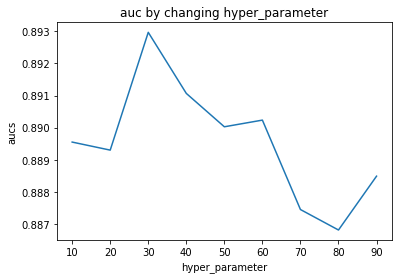

In [405]:
# # num_leaves
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

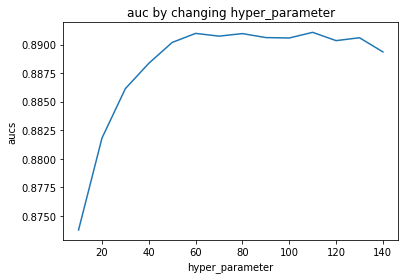

In [415]:
# # num_iterations
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

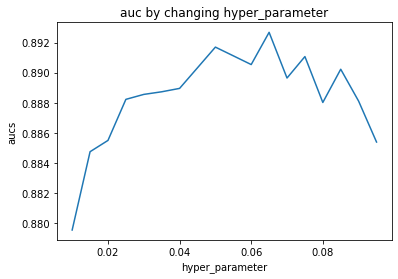

In [428]:
# # learning_rate
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

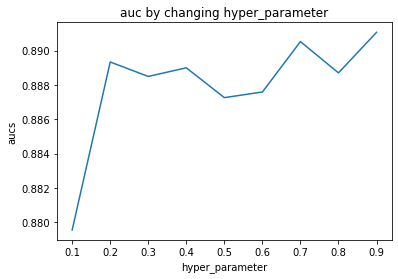

In [430]:
# # feature_fraction
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

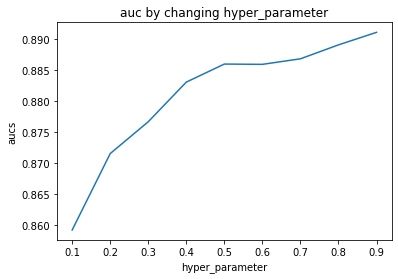

In [432]:
# # bagging_fraction
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

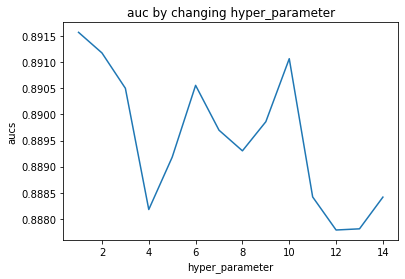

In [434]:
# # bagging_freq
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

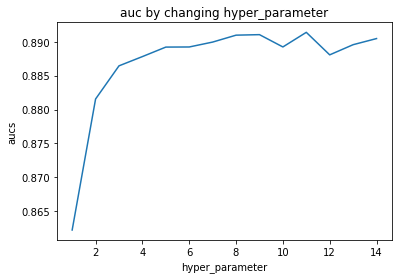

In [436]:
# # max_depth
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

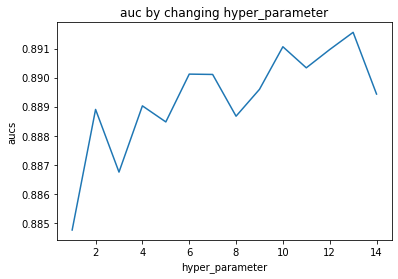

In [438]:
# # min_data_in_leaf
# plt.plot(parameter_list, aucs)
# plt.xlabel("hyper_parameter")
# plt.ylabel("aucs")
# plt.title("auc by changing hyper_parameter")
# plt.show()

In [292]:
Predictions[:,1]

array([0.193, 0.008, 0.026, ..., 0.006, 0.002, 0.005])

In [293]:
Predictions[:,1].shape

(10500,)

In [318]:
y_pred = np.where(Predictions[:, 1] < 0.5, 0, 1) # 閾値=0.5

In [295]:
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[9936,   60],
       [ 390,  114]])

In [296]:
print('accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('precision: {:.3f}'.format(precision_score(y_test, y_pred)))
precision = precision_score(y_test, y_pred)
print('recall: {:.3f}'.format(recall_score(y_test, y_pred)))
print('f1: {:.3f}'.format(f1_score(y_test, y_pred)))
print('log loss: {:.3f}'.format(log_loss(y_test, y_pred)))

accuracy: 0.957
precision: 0.655
recall: 0.226
f1: 0.336
log loss: 1.480


In [297]:
y_pred = np.where(Predictions[:, 0] < 0.5, 0, 1) # 閾値=0.5
recall = recall_score(y_test, y_pred)
print('recall: {:.3f}'.format(recall_score(y_test, y_pred)))

recall: 0.774


In [298]:
f1 = 2*(precision*recall)/(precision+recall)
f1

0.7095662166044239

In [367]:
# KS値
# K-S検定（コルモゴロフ-スミルノフ検定）
clf= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=25, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0, min_impurity_split=None,
        min_samples_leaf=1, min_samples_split=15,
        min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
        oob_score=False, random_state=0, verbose=0, warm_start=False)

clf.fit(X_train, y_train)
pre=clf.predict_proba(X_train)
pre_pd = pd.DataFrame(pre[:,1])
pre_pd['y'] = y_train
pre_pd

,0,y
0,0.433282,1.0
1,0.264303,1.0
2,0.489036,1.0
3,0.140868,1.0
4,0.291600,1.0
...,...,...
41995,0.001886,0.0
41996,0.006667,0.0
41997,0.000273,0.0
41998,0.000000,0.0


In [359]:
# 全特徴量の評価結果
# Importtance
importance_gbm = gbm.feature_importances_
importances_gbm = pd.DataFrame(importance_gbm, index = X_test.columns, columns=['importance'])
pd.set_option('display.max_rows', 60)
print(importances_gbm.shape)
importances_sort = importances_gbm.sort_values(by='importance', ascending=False)
importances_sort

(35, 1)


,importance
x1_term,650
x0_age,403
x10,378
x73,370
x3,260
x56,221
x5,220
x57,194
x55,134
x12,115


In [360]:
importances_sort.to_csv('./all_importance.csv')

In [361]:
with open('./all_importance.csv') as f:
    print(f.read())

,importance
x1_term,650
x0_age,403
x10,378
x73,370
x3,260
x56,221
x5,220
x57,194
x55,134
x12,115
x2_sex,112
x13,101
x17,99
x6,83
x4,83
x74,79
x53,75
x75,73
x9_T,71
x20,56
x52,53
x78,49
x45,40
x9_C,38
x42,38
x9_K,35
x9_Q,35
x76,34
x43,32
x9_D,30
x9_R,30
x77,29
x9_N,25
x9_H,16
x9_S,11



In [320]:
# import scipy.stats
# from sklearn.model_selection import RandomizedSearchCV
# LR_random = {LogisticRegression(): {"C": scipy.stats.uniform(0.00001, 1000),
#                                     "random_state": scipy.stats.randint(0, 100)}}
# #ランダムサーチ
# max_score = 0
# for model, param in LR_random.items():
#     clf =RandomizedSearchCV(model, param)
#     clf.fit(X_train_C, y_train)
#     perds_C = clf.predict_proba(X_test_C)
#     y_pred_C = np.where(perds_C[:, 1] < 0.7, 0, 1)
#     score = f1_score(y_test, y_pred_C, average="micro")

# # 最高スコア時の値を取得
#     if max_score < score:
#         max_score = score
#         best_model = model.__class__.__name__

# print("max_score:{}".format(max_score))
# print("best_param:{}".format(best_param))

In [321]:
# 変数のAUC
X_train_C = X_train.loc[:,['x0_age','x1_term','x9_C']].copy()
X_train_D = X_train.loc[:,['x0_age','x1_term','x9_D']].copy()
X_train_H = X_train.loc[:,['x0_age','x1_term','x9_H']].copy()
X_train_K = X_train.loc[:,['x0_age','x1_term','x9_K']].copy()
X_train_N = X_train.loc[:,['x0_age','x1_term','x9_N']].copy()
X_train_Q = X_train.loc[:,['x0_age','x1_term','x9_Q']].copy()
X_train_R = X_train.loc[:,['x0_age','x1_term','x9_R']].copy()
X_train_S = X_train.loc[:,['x0_age','x1_term','x9_S']].copy()
X_train_T = X_train.loc[:,['x0_age','x1_term','x9_T']].copy()

X_test_C = X_test.loc[:,['x0_age','x1_term','x9_C']].copy()
X_test_D = X_test.loc[:,['x0_age','x1_term','x9_D']].copy()
X_test_H = X_test.loc[:,['x0_age','x1_term','x9_H']].copy()
X_test_K = X_test.loc[:,['x0_age','x1_term','x9_K']].copy()
X_test_N = X_test.loc[:,['x0_age','x1_term','x9_N']].copy()
X_test_Q = X_test.loc[:,['x0_age','x1_term','x9_Q']].copy()
X_test_R = X_test.loc[:,['x0_age','x1_term','x9_R']].copy()
X_test_S = X_test.loc[:,['x0_age','x1_term','x9_S']].copy()
X_test_T = X_test.loc[:,['x0_age','x1_term','x9_T']].copy()

In [322]:
# ロジスティック回帰モデル
lr = LogisticRegression(C=961, random_state=32)

In [323]:
#ハイパーパラメータを調整しない場合
lr.fit(X_train_C, y_train)
y_pred_C = lr.predict_proba(X_test_C)

lr.fit(X_train_D, y_train)
y_pred_D = lr.predict_proba(X_test_D)

lr.fit(X_train_H, y_train)
y_pred_H = lr.predict_proba(X_test_H)

lr.fit(X_train_K, y_train)
y_pred_K = lr.predict_proba(X_test_K)

lr.fit(X_train_N, y_train)
y_pred_N = lr.predict_proba(X_test_N)

lr.fit(X_train_Q, y_train)
y_pred_Q = lr.predict_proba(X_test_Q)

lr.fit(X_train_R, y_train)
y_pred_R = lr.predict_proba(X_test_R)

lr.fit(X_train_S, y_train)
y_pred_S = lr.predict_proba(X_test_S)

lr.fit(X_train_T, y_train)
y_pred_T = lr.predict_proba(X_test_T)

In [324]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_C[:,1])
auc_C = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_D[:,1])
auc_D = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_H[:,1])
auc_H = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_K[:,1])
auc_K = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_N[:,1])
auc_N = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_Q[:,1])
auc_Q = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_R[:,1])
auc_R = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_S[:,1])
auc_S = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_T[:,1])
auc_T = metrics.auc(fpr, tpr)

In [325]:
print('auc_C: {:.3f}'.format(auc_C))
print('auc_D: {:.3f}'.format(auc_D))
print('auc_H: {:.3f}'.format(auc_H))
print('auc_K: {:.3f}'.format(auc_K))
print('auc_N: {:.3f}'.format(auc_N))
print('auc_Q: {:.3f}'.format(auc_Q))
print('auc_R: {:.3f}'.format(auc_R))
print('auc_S: {:.3f}'.format(auc_S))
print('auc_T: {:.3f}'.format(auc_T))

auc_C: 0.734
auc_D: 0.735
auc_H: 0.733
auc_K: 0.732
auc_N: 0.734
auc_Q: 0.735
auc_R: 0.735
auc_S: 0.735
auc_T: 0.727


In [326]:
# 合成変数
X_train_3 = X_train.loc[:,['x0_age','x1_term','x73']].copy()
X_train_4 = X_train.loc[:,['x0_age','x1_term','x74']].copy()
X_train_5 = X_train.loc[:,['x0_age','x1_term','x75']].copy()
X_train_6 = X_train.loc[:,['x0_age','x1_term','x76']].copy()
X_train_7 = X_train.loc[:,['x0_age','x1_term','x77']].copy()
X_train_8 = X_train.loc[:,['x0_age','x1_term','x78']].copy()

In [327]:
X_test_3 = X_test.loc[:,['x0_age','x1_term','x73']].copy()
X_test_4 = X_test.loc[:,['x0_age','x1_term','x74']].copy()
X_test_5 = X_test.loc[:,['x0_age','x1_term','x75']].copy()
X_test_6 = X_test.loc[:,['x0_age','x1_term','x76']].copy()
X_test_7 = X_test.loc[:,['x0_age','x1_term','x77']].copy()
X_test_8 = X_test.loc[:,['x0_age','x1_term','x78']].copy()

In [328]:
# ロジスティック回帰モデル
lr = LogisticRegression(C=961, random_state=32)

In [329]:
lr.fit(X_train_3, y_train)
y_pred_3 = lr.predict_proba(X_test_3)

lr.fit(X_train_4, y_train)
y_pred_4 = lr.predict_proba(X_test_4)

lr.fit(X_train_5, y_train)
y_pred_5 = lr.predict_proba(X_test_5)

lr.fit(X_train_6, y_train)
y_pred_6 = lr.predict_proba(X_test_6)

lr.fit(X_train_7, y_train)
y_pred_7 = lr.predict_proba(X_test_7)

lr.fit(X_train_8, y_train)
y_pred_8 = lr.predict_proba(X_test_8)

In [330]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_3[:,1])
auc_3 = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_4[:,1])
auc_4 = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_5[:,1])
auc_5 = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_6[:,1])
auc_6 = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_7[:,1])
auc_7 = metrics.auc(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_8[:,1])
auc_8 = metrics.auc(fpr, tpr)

In [331]:
print('auc_3: {:.3f}'.format(auc_3))
print('auc_4: {:.3f}'.format(auc_4))
print('auc_5: {:.3f}'.format(auc_5))
print('auc_6: {:.3f}'.format(auc_6))
print('auc_7: {:.3f}'.format(auc_7))
print('auc_8: {:.3f}'.format(auc_8))

auc_3: 0.733
auc_4: 0.794
auc_5: 0.735
auc_6: 0.735
auc_7: 0.735
auc_8: 0.737


In [332]:
# 結果予測

In [333]:
df_test = pd.read_csv('./dat_test', encoding='utf-8', sep=',')
df_test.shape

(21000, 73)

In [334]:
df_proc_test = df_test.copy()

In [335]:
df_proc_test['x0_age'] = df_proc_test['x0_age'].fillna(df_proc['x0_age'].median())

In [336]:
df_proc_test['x10'] = df_proc_test['x10'].fillna(df_proc['x10'].median())

In [337]:
df_proc_test['x58'] = df_proc_test['x58'].fillna(0)
df_proc_test['x59'] = df_proc_test['x59'].fillna(0)
df_proc_test['x60'] = df_proc_test['x60'].fillna(0)
df_proc_test['x61'] = df_proc_test['x61'].fillna(0)
df_proc_test['x62'] = df_proc_test['x62'].fillna(-1)
df_proc_test['x63'] = df_proc_test['x63'].fillna(0)
df_proc_test['x64'] = df_proc_test['x64'].fillna(99999999)
df_proc_test['x65'] = df_proc_test['x65'].fillna(0)
df_proc_test['x66'] = df_proc_test['x66'].fillna(0)
df_proc_test['x67'] = df_proc_test['x67'].fillna(99)
df_proc_test['x68'] = df_proc_test['x68'].fillna(0)
df_proc_test['x69'] = df_proc_test['x69'].fillna(0)
df_proc_test['x70'] = df_proc_test['x70'].fillna(0)
df_proc_test['x71'] = df_proc_test['x71'].fillna(-1)

In [338]:
# one hot encoding
df_proc_test = pd.get_dummies(df_proc_test, columns=['x9'])

In [339]:
drop_col = ['x14','x18','x19','x21','x22','x23','x27','x28','x29','x30','x31','x33','x34','x35','x36','x37','x38','x40','x49','x72']
df_proc_test = df_proc_test.drop(drop_col, axis=1)

In [340]:
df_proc_test['x6'] = df_proc_test['x6'].replace(99, 0)
df_proc_test['x67'] = df_proc_test['x67'].replace(99, 0)
df_proc_test['x63'] = df_proc_test['x63'].replace(0, 99999999)

In [341]:
df_proc_test = df_proc_test.drop(columns='x61')
df_proc_test = df_proc_test.drop(columns='x65')
df_proc_test = df_proc_test.drop(columns='x66')
df_proc_test = df_proc_test.drop(columns='x70')

In [342]:
# 下記も削除対象とする
cols =['x46', 'x48', 'x50', 'x51'] # 'x47'残す
df_proc_test = df_proc_test.drop(columns=cols)

In [343]:
df_proc_test['x73'] = (df_proc_test['x0_age'] + df_proc_test['x10'])/2
df_proc_test['x74'] = (df_proc_test['x5'] + df_proc_test['x6'])/2
df_proc_test['x75'] = (df_proc_test['x59'] + df_proc_test['x67'])/2
df_proc_test['x76'] = (df_proc_test['x59'] + df_proc_test['x68'])/2
df_proc_test['x77'] = (df_proc_test['x62'] + df_proc_test['x71'])/2
df_proc_test['x78'] = (df_proc_test['x63'] + df_proc_test['x64'])/2

In [344]:
del_col = ['x9_X','x7', 'x8', 'x11', 'x15', 'x16', 'x24', 'x25', 'x26', 'x32', 'x39','x41', 'x44', 'x47', 'x54', 'x58', 'x59', 'x60', 'x62', 'x63', 'x64','x67', 'x68', 'x69', 'x71']
df_proc_test = df_proc_test.drop(columns=del_col)

In [345]:
df_proc_test.shape

(21000, 35)

In [346]:
# 予測
Pred_proba = gbm.predict_proba(df_proc_test)

In [347]:
y_pred_proba = np.where(Pred_proba[:, 1] < 0.5, 0, 1) # 閾値=0.5
y_pred_proba.shape

(21000,)

In [348]:
nonzero = np.count_nonzero(y_pred_proba)
nonzero

293

In [349]:
df_proba = pd.DataFrame(data=Pred_proba, columns=['proba0', 'proba1'])
df_proba

,proba0,proba1
0,0.975767,0.024233
1,0.714086,0.285914
2,0.236839,0.763161
3,0.996870,0.003130
4,0.997630,0.002370
...,...,...
20995,0.997506,0.002494
20996,0.988465,0.011535
20997,0.998308,0.001692
20998,0.931951,0.068049


In [350]:
np.set_printoptions(precision=3, suppress=True)
data = pd.DataFrame()
data['dat_test_index'] = df_proc_test.index
data['x0_age'] = df_proc_test['x0_age']
data['x1_term'] = df_proc_test['x1_term']
data['x2_sex'] = df_proc_test['x2_sex']
data['x3'] = df_proc_test['x3']
data['proba_index'] = df_proba.index
data['proba0'] = df_proba['proba0'].round(decimals=3)
data['proba1'] = df_proba['proba1'].round(decimals=3)
data['pred'] = np.where(Pred_proba[:, 1] < 0.5, 0, 1)
data

,dat_test_index,x0_age,x1_term,x2_sex,x3,proba_index,proba0,proba1,pred
0,0,29.0,54,1,31,0,0.976,0.024,0
1,1,45.0,1,2,50,1,0.714,0.286,0
2,2,26.0,0,1,99,2,0.237,0.763,1
3,3,54.0,137,1,10,3,0.997,0.003,0
4,4,41.0,242,1,34,4,0.998,0.002,0
...,...,...,...,...,...,...,...,...,...
20995,20995,33.0,146,2,10,20995,0.998,0.002,0
20996,20996,42.0,15,1,10,20996,0.988,0.012,0
20997,20997,50.0,188,2,91,20997,0.998,0.002,0
20998,20998,35.0,1,1,10,20998,0.932,0.068,0


In [351]:
data.to_csv('./test_result_3.csv')

In [352]:
with open('./test_result_3.csv') as f:
    print(f.read())

,dat_test_index,x0_age,x1_term,x2_sex,x3,proba_index,proba0,proba1,pred
0,0,29.0,54,1,31,0,0.976,0.024,0
1,1,45.0,1,2,50,1,0.714,0.286,0
2,2,26.0,0,1,99,2,0.237,0.763,1
3,3,54.0,137,1,10,3,0.997,0.003,0
4,4,41.0,242,1,34,4,0.998,0.002,0
5,5,48.0,64,2,10,5,0.878,0.122,0
6,6,50.0,118,1,99,6,0.993,0.007,0
7,7,25.0,64,2,10,7,0.995,0.005,0
8,8,26.0,80,1,10,8,0.915,0.085,0
9,9,26.0,67,2,10,9,0.994,0.006,0
10,10,33.0,61,2,34,10,0.994,0.006,0
11,11,18.0,4,1,35,11,0.985,0.015,0
12,12,58.0,96,1,10,12,0.991,0.009,0
13,13,20.0,2,1,10,13,0.603,0.397,0
14,14,33.0,12,2,10,14,0.99,0.01,0
15,15,25.0,11,2,91,15,0.53,0.47,0
16,16,46.0,4,2,10,16,0.998,0.002,0
17,17,32.0,89,2,10,17,0.994,0.006,0
18,18,33.0,2,1,10,18,0.991,0.009,0
19,19,32.0,47,2,34,19,0.992,0.008,0
20,20,56.0,247,2,10,20,0.999,0.001,0
21,21,38.0,230,1,10,21,0.998,0.002,0
22,22,58.0,199,1,91,22,0.996,0.004,0
23,23,25.0,91,2,10,23,0.997,0.003,0
24,24,13.0,0,2,10,24,0.996,0.004,0
25,25,16.0,110,1,10,25,0.997,0.003,0
26,26,21.0,36,2,10,26,0.97